# ДОМАШНЕЕ ЗАДАНИЕ 2. Выбор модели

## Цель работы

- реализация собственных классов совместимых с библиотекой `sklearn`
- использование полиномиальной транcформации в моделях регрессии и классификации
- использование регуляризации в моделях регрессии и классификации
- выбор гиперпараметров и интерпретация кривых обучения

## Вариант

In [569]:
surname = "Панфилкин"  # Ваша фамилия

alph = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
w = [4, 42, 21, 21, 34,  1, 44, 26, 18, 43, 38, 26, 18, 43,  3, 49, 45,
        7, 42, 25,  4,  9, 36, 33, 31, 29,  5, 31,  4, 19, 24, 27, 33]
d = dict(zip(alph, w))
variant =  sum([d[el] for el in surname.lower()]) % 2 + 1
print("Ваш вариант - ", variant)

Ваш вариант -  1


## Подготовка

In [570]:
import numpy as np
import pandas as pd

from sklearn.base import is_regressor, BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.estimator_checks import check_estimator
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LogisticRegression

from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Зафиксируем random_state сразу
RANDOM_STATE = 0


## Задание 1. Реализация собственных классов и функций

⚠️ **Замечание.** 1) Нельзя пользоваться готовыми реализациями `sklearn`; 2) чтобы избежать случая с вырожденной матрицей при оценке параметров добавьте небольшую регуляризацию по умолчанию или используйте `lstsq` из пакета `numpy` или др. способ; 3) используйте `random_state=0`

Набор данных: Reg_A5.csv

#### 1. Реализуйте класс, предназначенный для оценки параметров линейной регрессии с регуляризацией совместимый с `sklearn`. Передаваемые параметры: 1) коэффициент регуляризации (`alpha`). Использовать метод наименьших квадратов с регуляризацией.

Вычисляем веса методом наименьших квадратов по формуле ридж регрессии:

$\hat{\theta_{\lambda}^R} = (X^T X + \lambda I)^{-1} X^T y$

$\lambda$ - коэффициент регуляризации

$I$ - единичная матрица размера $p \times p$

$X$ - матрица объекты-признаки размера $n \times p$

$y$ - вектор значений целевой переменной размера $n \times 1$

$\hat{\theta_{\lambda}^R}$ - вектор параметров линейной регрессии размера $p \times 1$

_(n - количество нааблюдений, p - количество признаков)_

In [571]:
class SSLinearRegression(BaseEstimator, RegressorMixin):
    def __init__(self, method: str = 'ridge', alpha: float = .1) -> None:
        '''alpha - коэффициент регуляризации (Ридж регрессия)'''

        self.method = method
        self.alpha = alpha

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'SSLinearRegression':
        # Проверка входных данных на соответствие требованиям sklearn:
        # X - матрица объекты-признаки размера n x p
        # y - вектор значений целевой переменной размера n x 1
        X, y = check_X_y(X, y)

        # Запоминаем количество признаков в обучающей выборке (без учета столбца единиц)
        # Нужно для прохождения проверок sklearn
        self.n_features_in_ = X.shape[1]

        # Добавление столбца единиц к матрице объекты-признаки для учета свободного члена в модели
        # Устраиваем так называемый fit_intercept в sklearn
        X_ = np.c_[np.ones(X.shape[0]), X]

        # Оценка параметров модели по формуле выше
        # P.S. Установим p = self.n_features_in_ + 1, так как мы добавили столбец единиц к матрице
        # объекты-признаки.
        I = np.eye(self.n_features_in_+1)
        # Не регуляризуем свободный член! Он может быть сколь угодно большим!
        I[0, 0] = 0
        # Для обратной матрицы используем псевдообратную матрицу (np.linalg.pinv),
        # так как матрица может быть вырожденной. Если матрица не вырожденная, то псевдообратная
        # матрица совпадает с обратной, так что все ок.
        coef = np.linalg.pinv(X_.T @ X_ + self.alpha * I) @ X_.T @ y

        # Запоминаем параметры модели как в sklearn - self.intercept_ и self.coef_
        self.intercept_ = coef[0]  # Первый элемент - свободный член
        self.coef_ = coef[1:]  # Остальные - параметры при признаках
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверка, что модель обучена
        check_is_fitted(self, 'coef_')

        # Проверка входных данных на соответствие требованиям sklearn:
        # X - матрица объекты-признаки размера n x p
        X = check_array(X)

        # Добавление столбца единиц к матрице объекты-признаки для учета свободного члена в модели
        X_ = np.c_[np.ones(X.shape[0]), X]
        
        # Предсказание значений целевой переменной
        # Испоользуем np.r_ для объединения вектора свободного члена и вектора параметров модели
        # Потому что хотим как в sklearn!
        return X_ @ np.r_[self.intercept_, self.coef_]


# Сразу проверяем совместимость с sklearn
check_estimator(SSLinearRegression())
is_regressor(SSLinearRegression())


True

#### 2. Реализуйте класс для стандартизации признаков в виде трансформации совместимый с `sklearn`. Передаваемые параметры: 1) `has_bias` (содержит ли  матрица вектор единиц), 2) `apply_mean` (производить ли центровку)

Параметры рассчитываем по следующей формуле:

$X_{centered} = \frac{X - \mu}{\sigma}$, где

$X$ - матрица признаков размера $n \times p$

$\mu$ - вектор средних по столбцам размера $p$

$\sigma$ - вектор стандартных отклонений по столбцам размера $p$

In [572]:
# Класс для стандартизации признаков в виде трансформации совместимый с sklearn.
# Передаваемые параметры:
#  - has_bias - содержит ли матрица вектор единиц
#  - apply_mean - применять ли центровку

class SSStandardTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, has_bias: bool = True, apply_mean: bool = True):
        '''has_bias - содержит ли матрица вектор единиц, apply_mean - применять ли центровку'''

        self.has_bias = has_bias
        self.apply_mean = apply_mean

    def fit(self, X: np.ndarray, y: np.ndarray = None) -> 'SSStandardTransformer':

        '''Обучение трансформера - оценка параметров mean_ и std_'''
        # Проверка входных данных на соответствие требованиям sklearn:
        # X - матрица объекты-признаки размера n x p
        X = check_array(X)

        # Если has_bias = True, то не учитываем первый столбец X в вычислениях mean_ и std_
        X_ = X[:, 1:] if self.has_bias else X

        # Если apply_mean = True, то вычисляем среднее по столбцам
        # Если apply_mean = False, то среднее по столбцам равно нулю, чтобы не было усреднения
        self.mean_ = X_.mean(axis=0) if self.apply_mean else np.zeros(X_.shape[1])

        # Вычисляем стандартное отклонение по столбцам
        self.std_ = X_.std(axis=0)

        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        
        '''Преобразование данных с использованием обученного трансформера'''
        # Проверка, что трансформер обучен
        check_is_fitted(self, 'std_')
        # Проверка входных данных на соответствие требованиям sklearn:
        # X - матрица объекты-признаки размера n x p
        X = check_array(X)
        # Не учитываем первый столбец X, если has_bias = True
        X_ = X[:, 1:] if self.has_bias else X
        # Выполняем центровку в не зависимости от apply_mean, т.к. mean_ = 0, при apply_mean = False
        X_ = (X_ - self.mean_) / self.std_
        # Обратно добавляем первый столбец X, если has_bias = True
        X_ = np.c_[X[:, 0], X_] if self.has_bias else X_
        return X_

    def fit_transform(self, X: np.ndarray, y: np.ndarray = None) -> np.ndarray:
        '''Обучение трансформера и преобразование данных'''
        
        return self.fit(X).transform(X)

# Совместимость с sklearn не буду проверять, так как он требует наличия других методов,
# которые не нужны для данной задачи

#### 3. Используя класс `Pipeline`, выполнить обучение линейной регрессии для всего набора данных с коэффициентом регуляризации равным `0.01`. Выведите значения параметров обученной модели. Отобразите исходные данные и график функции предсказания.

Данные

In [573]:
# Загрузка всех данных
X, y = np.loadtxt('data/Reg_A5.csv', delimiter=',', skiprows=1, unpack=True)
# Переведем X в двумерный массив (n_samples, n_features)
X = X.reshape(-1, 1)

Модель

In [574]:
# Создание объекта класса Pipeline
# ╟─Трансформер : Стандартизация признаков с центровкой, без смещения
# ╙─Регрессор   : Регуляризованная линейная регрессия с alpha = 0.01
pipeline = Pipeline([
    ('transformer', SSStandardTransformer(has_bias=False, apply_mean=True)),
    ('regression', SSLinearRegression(alpha=0.01))
])

# Обучение модели на всем наборе данных
pipeline.fit(X, y)

# Выведем значения параметров обученной модели
print("Параметры Pipeline")
print(f"╟─Трансформер    : {pipeline.named_steps['transformer'].get_params()}")
print(f"╙─Регрессор      : {pipeline.named_steps['regression'].get_params()}")
print(f"  ╟─Intercept    : {pipeline.named_steps['regression'].intercept_}")
print(f"  ╙─Coefficients : {pipeline.named_steps['regression'].coef_}")


Параметры Pipeline
╟─Трансформер    : {'apply_mean': True, 'has_bias': False}
╙─Регрессор      : {'alpha': 0.01, 'method': 'ridge'}
  ╟─Intercept    : 9.448921018562729
  ╙─Coefficients : [-0.40381569]


График

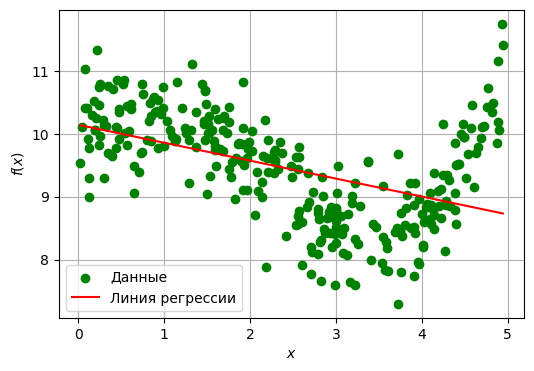

In [575]:
# Отображение наблюдений и линии регрессии
xx = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(X, y, color='green', label='Данные', zorder=2)
ax.plot(xx, pipeline.predict(xx), '-', color='red', label='Линия регрессии')
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
ax.legend()
ax.grid(True)
plt.show()


#### 4. Реализуйте функции для расчета `MSE` и `R^2` при отложенной выборке (`run_holdout`) и кросс-валидации (`run_cross_val`). Для кросс-валидации используйте **только** класс `KFold`. Выходными значениями должны быть `MSE` и `R^2` для обучающей и тестовой частей.

    *Шаблон кода:*

    ```python
    def run_holdout(model, X, y, train_size, random_state) -> dict:
        ...
        return scores


    def run_cross_val(model, X, y, n_splits, shuffle, random_state) -> dict:
        ...
        return scores
    ```

Рассчитаем оценки по формулам:

$MSE = \frac{1}{n} SSR = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

$R^2 = 1 - \frac{SSR}{SST} = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} = 1 - \frac{MSE}{D(y)}$

In [576]:
def ss_get_scores(y_pred, y_true, metrics = ['MSE', 'R2']) -> dict:
    scores = {}
    if 'MSE' in metrics:
        scores['MSE'] = np.mean((y_true - y_pred)**2)
    if 'R2' in metrics:
        # Определяем MSE, если он не был ранее определен для расчета R2
        score_MSE = np.mean((y_true - y_pred)**2) if 'MSE' not in scores else scores['MSE']
        scores['R2'] = 1 - score_MSE / np.var(y_true)
    # Сразу добавим возможность расчета Accuracy для задачи классификации далее
    if 'Accuracy' in metrics:
        # Кастим в int, т.к. в задаче классификации y_true и y_pred - целые числа
        # Точность определяем как долю правильных ответов
        # В sklearn есть функция accuracy_score, которая считает точность через 
        # np.average чтобы можно было передать в нее веса для объектов, но нам это не нужно
        scores['Accuracy'] = np.mean(y_true.astype(int) == y_pred.astype(int))

    return scores

In [577]:
# Функция для оценки качества модели на отложенной выборке. Я добавил параметр scores, чтобы можно 
# было вычислять несколько метрик сразу. По умолчанию вычисляются MSE и R2
def run_holdout(model, X, y, train_size, random_state, metrics = ['MSE', 'R2']) -> dict:
    # Разбиение данных на обучающую и проверочную выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, random_state=random_state
    )
    # Обучение модели
    model.fit(X_train, y_train)
    # Предсказание значений
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    # Вычисление метрик
    return {
        'train': ss_get_scores(y_train_pred, y_train, metrics),
        'test': ss_get_scores(y_test_pred, y_test, metrics)
    }

# Функция для оценки качества модели с использованием кросс-валидации
def run_cross_val(model, X, y, n_splits, shuffle, random_state, metrics = ['MSE', 'R2']) -> dict:
    # Создание генератора разбиений
    cv = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    
    # Подготовка словаря для хранения результатов
    scores = {
        'train': {metric: [] for metric in metrics},
        'test': {metric: [] for metric in metrics}
    }

    for train_index, test_index in cv.split(X):
        # Разбиение данных на обучающую и проверочную выборки
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Обучение модели
        model.fit(X_train, y_train)
        # Предсказание значений
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        # Вычисление метрик ИСПОЛЬЗУЯ ФУНКЦИЮ ss_get_scores
        scores_ = {
            'train': ss_get_scores(y_train_pred, y_train, metrics),
            'test': ss_get_scores(y_test_pred, y_test, metrics)
        }

        # Добавление метрик в словарь scores
        for key in scores_:
            for metric in scores_[key]:
                scores[key][metric].append(scores_[key][metric])

    # Усреднение метрик по всем фолдам
    for key in scores:
        for metric in scores[key]:
            scores[key][metric] = np.mean(scores_[key][metric])

    return scores


#### 5. Выведите значения `MSE` и `R^2`, полученные посредством функций `run_holdout` и `run_cross_val`. Использовать следующие параметры:
    - `train_size=0.75`, 
    - `n_splits=4`, 
    - `shuffle=True`, 
    - `random_state=0`

In [578]:
holdout_scores = run_holdout(pipeline, X, y, train_size=0.75, random_state=RANDOM_STATE)
cross_val_scores = run_cross_val(
    pipeline, X, y, n_splits=4, shuffle=True, random_state=RANDOM_STATE
)

print("Holdout scores:")
display(pd.DataFrame(holdout_scores))
print("Cross-val scores:")
display(pd.DataFrame(cross_val_scores))


Holdout scores:


,train,test
MSE,0.524679,0.667696
R2,0.263167,0.109510


Cross-val scores:


,train,test
MSE,0.566728,0.540096
R2,0.213862,0.253510


## Задание 2. Регрессия и кросс-валидация

⚠️ **Замечание**:
- Используйте ранее реализованные классы и функции
- Разбейте исходные данные на обучающее и тестовое подмножества в соотношении 70 на 30, `random_state=0`
- Для выбора гиперпараметров используйте два подхода: 1) с отложенной выборкой, 2) с кросс-валидацией
- Параметры разбиения для выбора гиперпараметров используйте те, что в п.5 задания 1

Дано множество наблюдений (см. набор данных к заданию), модель - линейная регрессия (без регуляризации, с нормализацией). Найти степень полинома с минимальной ошибкой на проверочном подмножестве, определить среднеквадратическую ошибку на тестовом подмножестве (степень полинома от 1 до 25).  Сделать заключение о влиянии степени полинома регуляризации.

Построить:
- диаграмму разброса исходных данных
- график зависимости среднеквадратической ошибки (`MSE`) от степени полинома для обучающего и проверочного подмножеств
- график зависимости коэффициента детерминации (`R^2`) от степени полинома для обучающего и проверочного подмножеств
- функцию регрессии (наилучший случай) + исходные данные

Набор данных: Reg_A5.csv

#### 1. Данные

In [579]:
# Загрузим данные из data/Reg_A5.csv, там два столбца - X и y
X, y = np.loadtxt('data/Reg_A5.csv', delimiter=',', skiprows=1, unpack=True)
# Переведем X в двумерный массив (n_samples, n_features)
X = X.reshape(-1, 1)

# Разбиение данных на обучающую и тестовую выборки в соотношении 70 на 30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

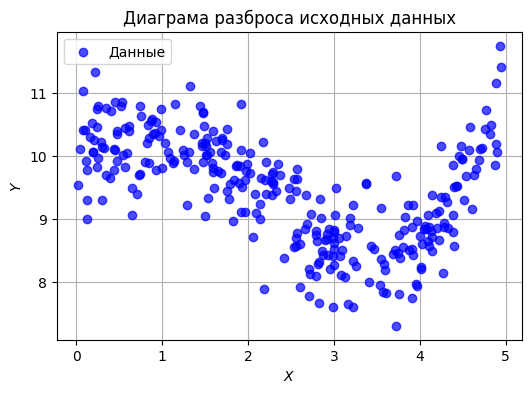

In [580]:
# Диаграма разброса исходных данных
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(X, y, color='blue', label='Данные', zorder=2, alpha=0.7)
ax.set_title('Диаграма разброса исходных данных')
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.grid(True)
ax.legend()
plt.show()

#### 2. Поиск лучшей степени полинома

Вычисление метрик

In [581]:
%%time
# Список степеней полинома
degrees = np.arange(1, 25+1)

# Словарь для хранения результатов: scores[method][degree][metric]
# использую defaultdict, чтобы не проверять наличие ключа
# lambda нужна, так как defaultdict требует передачи функции, а не ее вызова
scores = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# Рассчитаем метрики для каждой степени полинома
for degree in degrees:
    # Создание модели
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('transformer', SSStandardTransformer(has_bias=False, apply_mean=True)),
        ('regression', SSLinearRegression(alpha=.0))
    ])
    # Вычисление метрик
    scores_ = {
        'holdout': run_holdout(
            pipeline, X_train, y_train,
            train_size=0.75, random_state=RANDOM_STATE
        ),
        'cross_val': run_cross_val(
            pipeline, X_train, y_train,
            n_splits=4, shuffle=True, random_state=RANDOM_STATE)
    }

    for method in scores_.keys():
        for key in scores_[method].keys():
            for metric in scores_[method][key].keys():
                scores[method][key][metric].append(scores_[method][key][metric])

CPU times: total: 234 ms
Wall time: 218 ms


Построение графиков

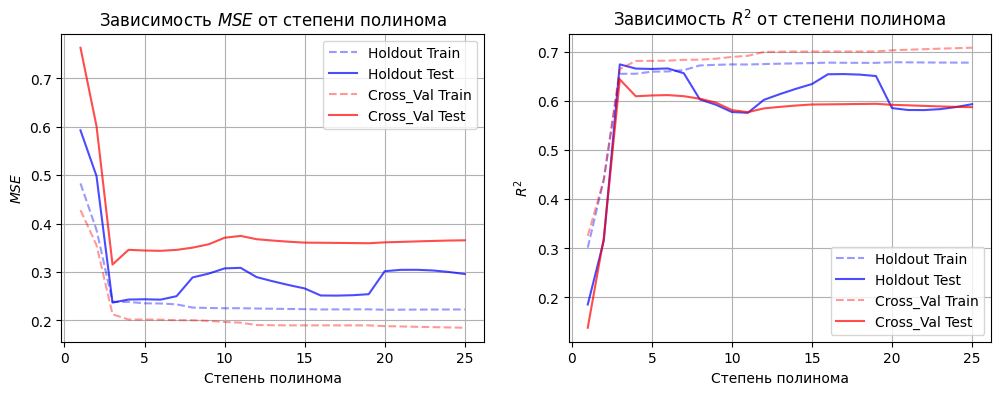

In [582]:
# Графики
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Для каждого метода с цветом
for method, color in zip(scores, ['blue', 'red']):
    # Для каждой метрики с прозрачностью цвета и стилем линии
    for key, color_alpha, line in zip(scores[method], [.4, .7], ['--', '-']):
        ax[0].plot(
            degrees, scores[method][key]['MSE'],
            label=f'{method} {key}'.title(),
            color=color, alpha=color_alpha,
            linestyle=line
        )
        ax[1].plot(
            degrees, scores[method][key]['R2'],
            label=f'{method} {key}'.title(),
            color=color, alpha=color_alpha,
            linestyle=line
        )

# Настройка графиков для всех осей и метрик
for ax_, metric in zip(ax, ['MSE', 'R^2']):
    ax_.set_title(f'Зависимость ${metric}$ от степени полинома')
    ax_.set_xlabel('Степень полинома')
    ax_.set_ylabel(f'${metric}$')
    ax_.grid(True)
    ax_.legend()
plt.show()


Заключение о влиянии степени полинома

При обучении модели, увеличение степени полинома сначала повышает обобщающую способность модели - ошибка уменьшается на обучающих и проверочных данных
однако после определенной степени ошибка начинает расти - модель теряет обобщающую способность, становится слишком гибкой, т.е. переобучается.
Мы выбираем степень полинома (или любой другой гиперпараметр) таким образом, чтобы не недообучить и не переобучить модель, т.е. значение параметра
при котором значение ошибки будет минимальным на проверочном множестве.

Выбор лучшей степени

Тут я выбираю лучшую степень по метрике MSE (можно и по R^2 - без разницы) кросс-валидации, так как holdout может давать разные значения метрик и потому кросс-валидации больше верим

In [583]:
# Степень полинома с наименьшей среднеквадратической ошибкой и наибольшим коэффициентом детерминации
best_degrees = {
    method: {
        'MSE': np.argmin(scores[method]['test']['MSE']) + 1,
        'R2': np.argmax(scores[method]['test']['R2']) + 1
    }
    for method in scores
}

print("Лучшие степени:")
display(pd.DataFrame(best_degrees))
degree = best_degrees['cross_val']['MSE']
print(f"Возьмем лучшую степень полинома по метрике MSE для кросс-валидации: {degree}")

Лучшие степени:


,holdout,cross_val
MSE,3,3
R2,3,3


Возьмем лучшую степень полинома по метрике MSE для кросс-валидации: 3


Модель с лучшей степенью

In [584]:
# Создание объекта класса Pipeline:
# ╟──полиномиальные признаки: PolynomialFeatures
# ║  ╙──степень полинома: best_degree, без свободного члена (он добавится в SSLinearRegression)
# ╟──трансформер: SSStandardTransformer
# ║  ╙──без смещения, со стандартизацией
# ╙──регрессор: SSLinearRegression
#    ╙──без регуляризации

pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
    ('transformer', SSStandardTransformer(has_bias=False, apply_mean=True)),
    ('regression', SSLinearRegression(alpha=.0))
])

# Обучение модели
pipeline.fit(X_train, y_train)

# Выведем значения параметров обученной модели
print("Параметры Pipeline")
print(f"╟─Трансформер    : {pipeline.named_steps['transformer'].get_params()}")
print(f"╟─Полиномиальные : {pipeline.named_steps['poly'].get_params()}")
print(f"╙─Регрессор      : {pipeline.named_steps['regression'].get_params()}")
print(f"  ╟─Intercept    : {pipeline.named_steps['regression'].intercept_}")
print(f"  ╙─Coefficients : {pipeline.named_steps['regression'].coef_}")

# Метрики для тестовой выборки
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
scores_train = ss_get_scores(y_train, y_pred_train)
scores = ss_get_scores(y_test, y_pred)
print("\nМетрики для обучающей выборки")
print(f"╟─MSE: {scores_train['MSE']:.4f}")
print(f"╙─R2 : {scores_train['R2']:.4f}")
print("Метрики для тестовой выборки")
print(f"╟─MSE: {scores['MSE']:.4f}")
print(f"╙─R2 : {scores['R2']:.4f}")



Параметры Pipeline
╟─Трансформер    : {'apply_mean': True, 'has_bias': False}
╟─Полиномиальные : {'degree': 3, 'include_bias': False, 'interaction_only': False, 'order': 'C'}
╙─Регрессор      : {'alpha': 0.0, 'method': 'ridge'}
  ╟─Intercept    : 9.45043867933788
  ╙─Coefficients : [ 2.03844927 -8.29778619  6.07104605]

Метрики для обучающей выборки
╟─MSE: 0.2358
╙─R2 : 0.4936
Метрики для тестовой выборки
╟─MSE: 0.2230
╙─R2 : 0.5166


Графики регрессии и данных

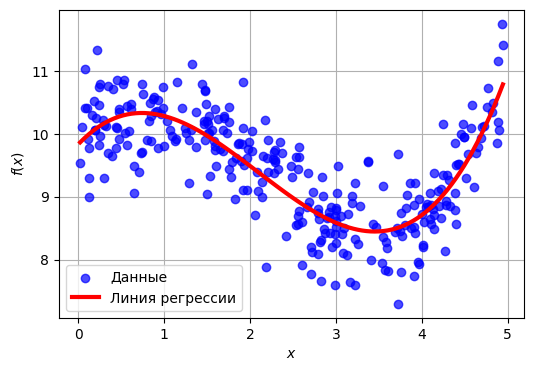

In [585]:
xx = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(X, y, color='blue', label='Данные', zorder=2, alpha=0.7)
# bold line
ax.plot(xx, pipeline.predict(xx), '-', color='red', label='Линия регрессии', linewidth=3)
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')

ax.legend()
ax.grid(True)
plt.show()

## Задание 3. Классификация и кросс-валидация (Вариант 1)

⚠️ **Замечание**:
- Используйте класс логистической регрессии из `sklearn` со следующими параметрами:
    - `penalty='l2'`
    - `fit_intercept=True`
    - `max_iter=100`
    - `C=1e5`
    - `solver='liblinear'`
    - `random_state=12345`
- Разбейте исходные данные на обучающее и тестовое подмножества в соотношении 70 на 30, `random_state=0`
- Для выбора гиперпараметров используйте два подхода: 1) с отложенной выборкой, 2) с кросс-валидацией
- Для кросс-валидации можно использовать функцию `cross_validate` из `sklearn`
- Параметры разбиения для выбора гиперпараметров используйте те, что в п.5 задания 1

Дано множество наблюдений (см. набор данных к заданию), классификатор - логистическая регрессия. Найти степень полинома с минимальной ошибкой на проверочном подмножестве, определить долю правильных классификаций на тестовом подмножестве. Сделать заключение о влиянии степени полинома регуляризации.

Построить:
- диаграмму разброса исходных данных
- график зависимости доли правильных классификаций от степени полинома для обучающего и проверочного подмножеств
- график зависимости доли правильных классификаций от количества итераций для обучающего и проверочного подмножеств для наилучшего случая
- результат классификации для наилучшего случая (степень полинома) для обучающего и тестового подмножеств

Набор данных: Cl_A5_V1.csv

#### 1. Данные

In [586]:
# Загрузка данных
X1, X2, y = np.loadtxt('data/Cl_A5_V2.csv', delimiter=',', skiprows=1, unpack=True)
X1, X2 = X1.reshape(-1, 1), X2.reshape(-1, 1)
# Объединение признаков в одну матрицу
X = np.hstack([X1, X2])

# Разбиение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=RANDOM_STATE
)

In [587]:
# Вывод статистики по количеству наблюдений для каждого класса
print("Количество наблюдений в классах:")
print(f"╟─Класс 0: {np.sum(y == 0)}")
print(f"╙─Класс 1: {np.sum(y == 1)}")

Количество наблюдений в классах:
╟─Класс 0: 250
╙─Класс 1: 250


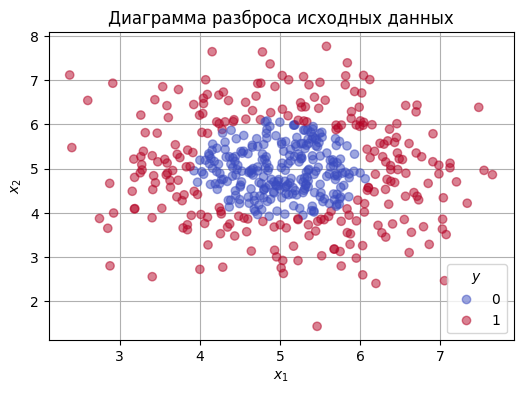

In [588]:
# Построим график зависимости y от X1 и X2.
# По осям отложены значения X1 и X2, а цветом обозначено значение y.
fig, ax = plt.subplots(figsize=(6, 4))
ax.title.set_text('Диаграмма разброса исходных данных')
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', label='Данные', zorder=2, alpha=0.5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
# Легенда для разных цветов
ax.legend(*ax.collections[0].legend_elements(), title='$y$')
ax.grid(True)
plt.show()

#### 2. Выбор лучшей степени полинома

Вычисление метрик

In [589]:
%%time

degrees = np.arange(1, 25+1)

# Аналогично используем defaultdict, чтобы не плодить код
scores = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for degree in degrees:
    # Pipeline: PolynomialFeatures -> LogisticRegression
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('regression', LogisticRegression(
            penalty='l2', fit_intercept=True, max_iter=100, C=1e5,
            solver='liblinear', random_state=12345
        ))
    ])

    # Метрики
    # P.S. Решил использовать свои функции, чтобы не плодить код из-за разной
    # структуры возвращаемых значений
    scores_ = {
        'holdout': run_holdout(
            pipeline, X_train, y_train,
            train_size=0.75, random_state=RANDOM_STATE,
            metrics=['Accuracy']
        ),
        'cross_val': run_cross_val(
            pipeline, X_train, y_train,
            n_splits=4, shuffle=True, random_state=RANDOM_STATE,
            metrics=['Accuracy']
        )
    }

    for method in scores_.keys():
        for key in scores_[method].keys():
            for metric in scores_[method][key].keys():
                scores[method][key][metric].append(scores_[method][key][metric])

CPU times: total: 1.44 s
Wall time: 1.47 s


Построение графиков

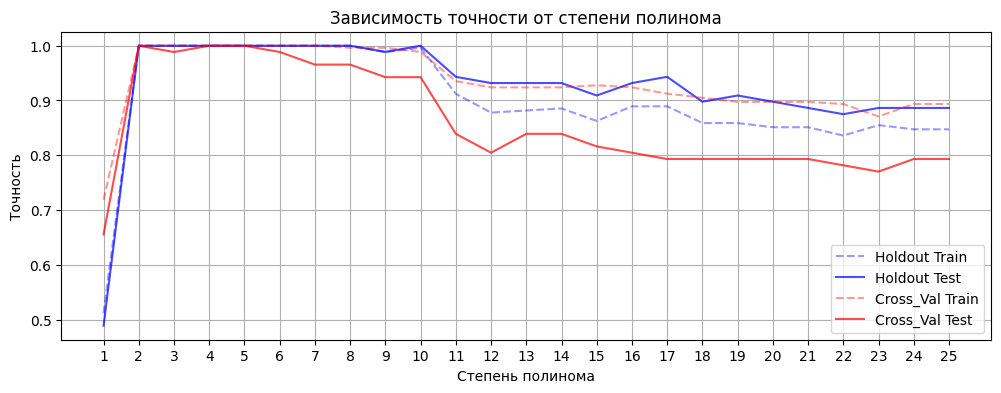

In [590]:
# Графики
fig, ax = plt.subplots(figsize=(12, 4))

# Для каждого метода с цветом
for method, color in zip(scores.keys(), ['blue', 'red']):
    for key, color_alpha, line in zip(scores[method].keys(), [.4, .7], ['--', '-']):
        ax.plot(
            degrees, scores[method][key]['Accuracy'],
            label=f'{method} {key}'.title(),
            color=color, alpha=color_alpha,
            linestyle=line
        )

# Настройка графиков для всех осей и метрик
ax.set_title(f'Зависимость точности от степени полинома')
ax.set_xlabel('Степень полинома')
ax.set_ylabel(f'Точность')
ax.set_xticks(degrees)
ax.grid(True)
ax.legend()
plt.show()

Заключение о влиянии степени полинома (аналогичное)

При обучении модели, увеличение степени полинома сначала повышает обобщающую способность модели - ошибка уменьшается на обучающих и проверочных данных
однако после определенной степени ошибка начинает расти - модель теряет обобщающую способность, становится слишком гибкой, т.е. переобучается.
Мы выбираем степень полинома (или любой другой гиперпараметр) таким образом, чтобы не недообучить и не переобучить модель, т.е. значение параметра
при котором значение ошибки будет минимальным на проверочном множестве.

Выбор лучшей степени

In [591]:
# Степень полинома с наименьшей среднеквадратической ошибкой и наибольшим коэффициентом детерминации
best_degrees = {
    method: {
        'Accuracy': np.argmax(scores[method]['test']['Accuracy']) + 1,
    }
    for method in scores.keys()
}

print("Лучшие степени:")
display(pd.DataFrame(best_degrees))
degree = best_degrees['cross_val']['Accuracy']
print(f"Возьмем лучшую степень полинома по точности для кросс-валидации: {degree}")

Лучшие степени:


,holdout,cross_val
Accuracy,2,2


Возьмем лучшую степень полинома по точности для кросс-валидации: 2


#### 3. Выбор лучшего числа максимальной итерации

Вычисление метрик

In [592]:
%%time

iterations = np.arange(1, 100+1)

scores = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for iteration in iterations:
    # Pipeline: PolynomialFeatures -> LogisticRegression
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('regression', LogisticRegression(
            penalty='l2', fit_intercept=True, max_iter=iteration, C=1e5,
            solver='liblinear', random_state=12345
        ))
    ])

    scores_ = {
        'holdout': run_holdout(
            pipeline, X_train, y_train,
            train_size=0.75, random_state=RANDOM_STATE,
            metrics=['Accuracy']
        ),
        'cross_val': run_cross_val(
            pipeline, X_train, y_train,
            n_splits=4, shuffle=True, random_state=RANDOM_STATE,
            metrics=['Accuracy']
        )
    }

    for method in scores_.keys():
        for key in scores_[method].keys():
            for metric in scores_[method][key].keys():
                scores[method][key][metric].append(scores_[method][key][metric])


c:\Users\SilkSlime\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\SilkSlime\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\SilkSlime\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\SilkSlime\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\SilkSlime\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of

CPU times: total: 1.19 s
Wall time: 1.15 s


Построение графиков

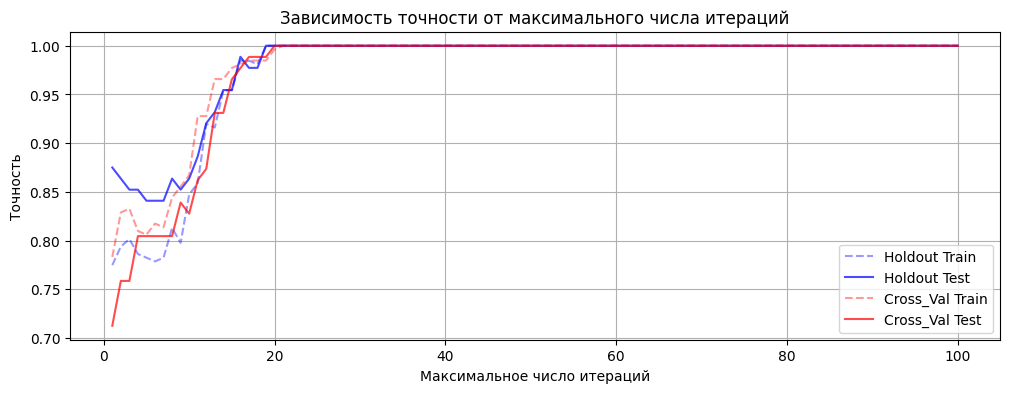

In [593]:
# Графики
fig, ax = plt.subplots(figsize=(12, 4))

# Для каждого метода с цветом
for method, color in zip(scores.keys(), ['blue', 'red']):
    for key, color_alpha, line in zip(scores[method].keys(), [.4, .7], ['--', '-']):
        ax.plot(
            iterations, scores[method][key]['Accuracy'],
            label=f'{method} {key}'.title(),
            color=color, alpha=color_alpha,
            linestyle=line
        )

# Настройка графиков для всех осей и метрик
ax.set_title(f'Зависимость точности от максимального числа итераций')
ax.set_xlabel('Максимальное число итераций')
ax.set_ylabel(f'Точность')
ax.grid(True)
ax.legend()
plt.show()

Выбор лучшего числа максимальной итерации

In [594]:
# Степень полинома с наименьшей среднеквадратической ошибкой и наибольшим коэффициентом детерминации
best_iteration = {
    'holdout': {'Accuracy': np.argmax(scores['holdout']['test']['Accuracy']) + 1},
    'cross_val': {'Accuracy': np.argmax(scores['cross_val']['test']['Accuracy']) + 1}
}

print("Лучшие числа максимальных итераций:")
display(pd.DataFrame(best_iteration))
iteration = best_iteration['cross_val']['Accuracy']
print(f"Возьмем лучшее значение максимального числа итераций по точности для кросс-валидации: {iteration}")

Лучшие числа максимальных итераций:


,holdout,cross_val
Accuracy,19,20


Возьмем лучшее значение максимального числа итераций по точности для кросс-валидации: 20


#### 4. Построение модели с лучшими параметрами

Модель и ее параметры

In [595]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
    ('regression', LogisticRegression(
        penalty='l2', fit_intercept=True, max_iter=iteration, C=1e5,
        solver='liblinear', random_state=12345
    ))
])

pipeline.fit(X_train, y_train)

# Выведем значения параметров обученной модели
print("Параметры Pipeline")
print(f"╟─Трансформер       : {pipeline.named_steps['poly']}")
print(f"╙─Классификатор     : {pipeline.named_steps['regression']}")
print(f"   ╟─Коэффициенты   : {pipeline.named_steps['regression'].coef_}")
print(f"   ╙─Свободный член : {pipeline.named_steps['regression'].intercept_}")

# Метрики
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)

scores_train = ss_get_scores(y_train, y_pred_train, metrics=['Accuracy'])
scores = ss_get_scores(y_test, y_pred, metrics=['Accuracy'])
print("\nМетрики для обучающей выборки")
print(f"╙─Точность: {scores_train['Accuracy']:.4f}")
print("Метрики для тестовой выборки")
print(f"╙─Точность: {scores['Accuracy']:.4f}")


Параметры Pipeline
╟─Трансформер       : PolynomialFeatures(include_bias=False)
╙─Классификатор     : LogisticRegression(C=100000.0, max_iter=20, random_state=12345,
                   solver='liblinear')
   ╟─Коэффициенты   : [[-125.86972798 -122.64297112   12.27014376    0.62221811   11.98855788]]
   ╙─Свободный член : [605.46450898]

Метрики для обучающей выборки
╙─Точность: 1.0000
Метрики для тестовой выборки
╙─Точность: 1.0000


c:\Users\SilkSlime\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Результат классификации для наилучшего случая (степень полинома) для обучающего и тестового подмножеств

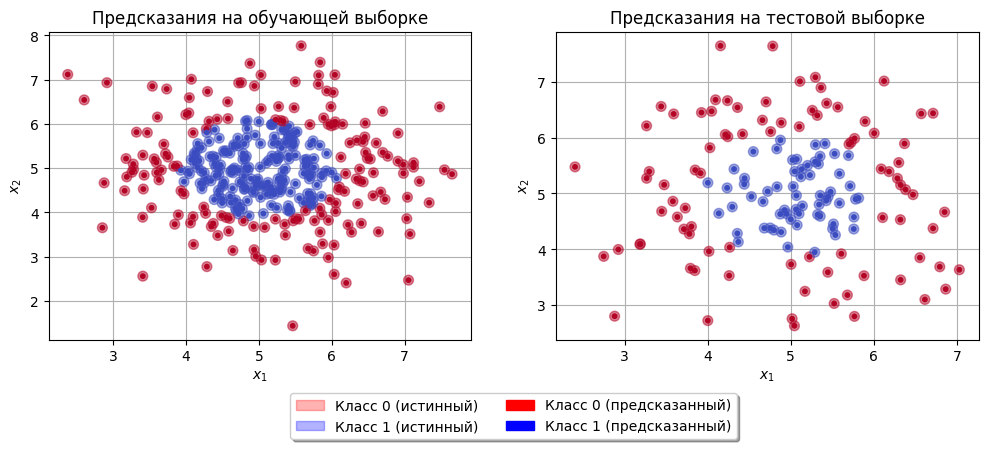

In [596]:
# График
fig, ax = plt.subplots(1, 2, figsize=(12, 4))


ax[0].set_title('Предсказания на обучающей выборке')
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', label='Данные', zorder=2, alpha=0.5, s=50)
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_pred_train, cmap='coolwarm', label='Данные', zorder=2, alpha=1, s=10)

ax[1].set_title('Предсказания на тестовой выборке')
ax[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', label='Данные', zorder=2, alpha=0.5, s=50)
ax[1].scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap='coolwarm', label='Данные', zorder=2, alpha=1, s=10)

# Легенда будет одна на двоих по серединке снизу
ax[0].legend(handles=[
    mpatches.Patch(color='red', label='Класс 0 (истинный)', alpha=0.3),
    mpatches.Patch(color='blue', label='Класс 1 (истинный)', alpha=0.3),
    mpatches.Patch(color='red', label='Класс 0 (предсказанный)', alpha=1),
    mpatches.Patch(color='blue', label='Класс 1 (предсказанный)', alpha=1),
],
    loc='upper center', bbox_to_anchor=(1.1, -0.15),
    ncol=2, fancybox=True, shadow=True
)

for a in ax:
    a.grid(True)
    a.set_xlabel('$x_1$')
    a.set_ylabel('$x_2$')

plt.show()